# Gridworld with Block Penalty: MDP (VI/PI) + DQN

This notebook implements a 4×4 Gridworld aligned with your figure and adds a **block penalty of –5** whenever an action does *not* change the position (i.e., bumping into walls).

What’s included:
- **Environment** with bottom-origin indexing (row 0 = bottom), **instant rewards** per cell, **goal=+10**, **pit=–10**, and **block penalty=–5** for invalid moves.
- **MDP solutions**: Value Iteration & Policy Iteration.
- **DQN**: small MLP, replay buffer, target network, ε-greedy, one-hot state.
- Quick runners for MDP and DQN + a tiny greedy evaluation.





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


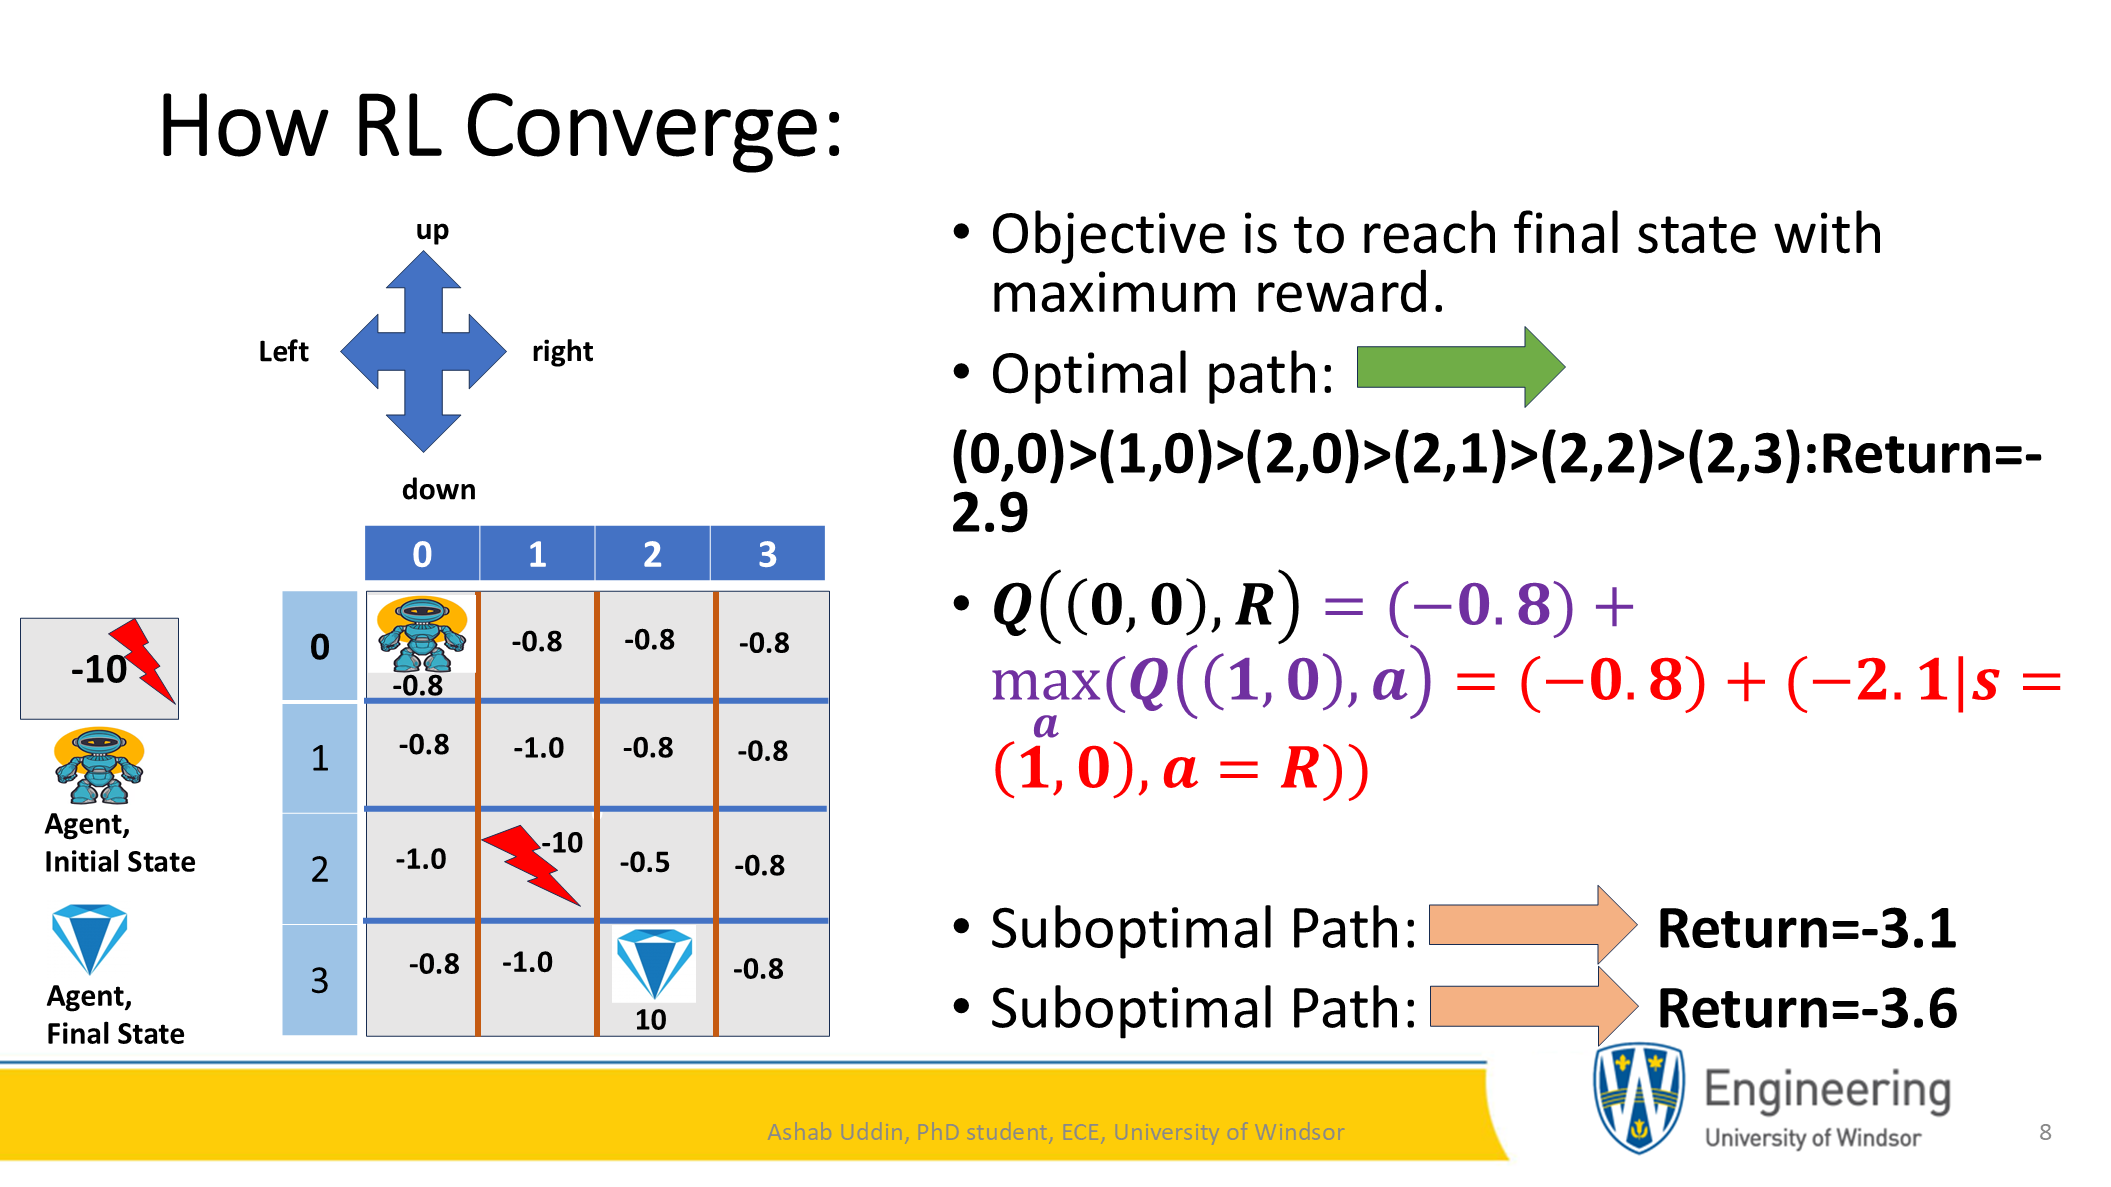

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # follow the prompt

from IPython.display import Image, display
from pathlib import Path

img_path = Path('/content/drive/MyDrive/Colab Notebooks/DRL_Workshop/gridworld.png')
display(Image(filename=str(img_path), width=2000))

In [ ]:
import math
import random
from dataclasses import dataclass
from typing import Tuple, Dict, List

import numpy as np

# If PyTorch isn't installed in your runtime, switch to a runtime with PyTorch.
import torch
import torch.nn as nn
import torch.optim as optim

# -----------------------------
# Gridworld Environment
# -----------------------------

ACTIONS = {0: (-1, 0),  # up
           1: (1, 0),   # down
           2: (0, -1),  # left
           3: (0, 1)}   # right
ACTION_NAMES = {0: "↑", 1: "↓", 2: "←", 3: "→"}

@dataclass
class GridworldConfig:
    height: int = 4
    width: int = 4
    gamma: float = 0.99
    start: Tuple[int, int] = (0, 0)      # bottom-left
    goal: Tuple[int, int]  = (3, 2)      # top row, col 2 (as in the figure) #Test for (2,2):keep (3,2)=10
    pit: Tuple[int, int]   = (2, 1)      # one row below top, col 1
    goal_reward: float = 10.0
    pit_reward: float  = -10.0
    block_penalty: float = -5.0          # penalty if action doesn't change position
    instant_rewards: np.ndarray = None   # per-cell *instant* reward

    def __post_init__(self):
        if self.instant_rewards is None:
            # Define rows from BOTTOM(0) to TOP(3); match the figure annotations
            self.instant_rewards = np.array([
                [-0.8, -0.8, -0.8, -0.8],   # row 0 (bottom)
                [-0.8, -1.0, -0.8, -0.8],   # row 1
                [-1.0, -10., -0.5, -0.8],   # row 2 (pit at (2,1)) #alternative [-1.0, -10., -0.5, -0.8],
                [-0.8, -1.0, 10, -0.8],   # row 3 (goal at (3,2))
            ], dtype=np.float32)


class Gridworld:
    """Rows indexed from bottom (0) to top (H-1)."""
    def __init__(self, cfg: GridworldConfig):
        self.cfg = cfg
        self.H, self.W = cfg.height, cfg.width
        self.reset()

    def in_bounds(self, r, c):
        return 0 <= r < self.H and 0 <= c < self.W

    def is_terminal(self, s):
        return s == self.cfg.goal or s == self.cfg.pit

    def step(self, action: int):
        if self.is_terminal(self.s):
            return self.s, 0.0, True, {}

        r, c = self.s
        dr, dc = ACTIONS[action]
        nr, nc = r + dr, c + dc

        if not self.in_bounds(nr, nc):
            # Invalid move → stay in place + block penalty
            nr, nc = r, c
            reward = float(self.cfg.block_penalty)
        else:
            # Normal instant reward
            reward = float(self.cfg.instant_rewards[nr, nc])
            # Override for terminals
            if (nr, nc) == self.cfg.goal:
                reward = self.cfg.goal_reward
            elif (nr, nc) == self.cfg.pit:
                reward = self.cfg.pit_reward

        self.s = (nr, nc)
        done = self.is_terminal(self.s)
        return self.s, reward, done, {}

    def reset(self):
        self.s = tuple(self.cfg.start)
        return self.s

    def all_states(self) -> List[Tuple[int, int]]:
        return [(r, c) for r in range(self.H) for c in range(self.W)]

    def transitions(self, s, a):
        """Deterministic transitions; returns list of (prob, next_s, reward)."""
        r, c = s
        dr, dc = ACTIONS[a]
        nr, nc = r + dr, c + dc
        if not self.in_bounds(nr, nc):
            # stay in place + block penalty
            nr, nc = r, c
            reward = float(self.cfg.block_penalty)
        else:
            reward = float(self.cfg.instant_rewards[nr, nc])
            if (nr, nc) == self.cfg.goal:
                reward = self.cfg.goal_reward
            elif (nr, nc) == self.cfg.pit:
                reward = self.cfg.pit_reward
        return [(1.0, (nr, nc), reward)]





# -----------------------------
# DQN
# -----------------------------

class QNet(nn.Module):
    def __init__(self, obs_size, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, n_actions)
        )
    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.buffer = []
        self.pos = 0
    def push(self, s, a, r, ns, d):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.pos] = (s, a, r, ns, d)
        self.pos = (self.pos + 1) % self.capacity
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, ns, d = map(np.array, zip(*batch))
        return s, a, r, ns, d
    def __len__(self):
        return len(self.buffer)

def one_hot_state(env: Gridworld, s: Tuple[int, int]) -> np.ndarray:
    vec = np.zeros(env.H * env.W, dtype=np.float32)
    idx = s[0] * env.W + s[1]
    vec[idx] = 1.0
    return vec

def train_dqn(env: Gridworld,
              episodes=2000,
              batch_size=64,
              gamma=0.99,
              lr=1e-3,
              eps_start=1.0,
              eps_end=0.05,
              eps_decay=0.997,
              target_sync=100,
              max_steps=50):
    obs_size = env.H * env.W
    n_actions = len(ACTIONS)
    device = torch.device("cpu")

    policy_net = QNet(obs_size, n_actions).to(device)
    target_net = QNet(obs_size, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    buffer = ReplayBuffer(5000)

    epsilon = eps_start
    rewards_hist = []

    for ep in range(episodes):
        s = env.reset()
        ep_reward = 0.0
        for step in range(max_steps):
            if random.random() < epsilon:
                a = random.randrange(n_actions)
            else:
                with torch.no_grad():
                    state_v = torch.tensor(one_hot_state(env, s)).unsqueeze(0).to(device)
                    #print(state_v)
                    q_vals = policy_net(state_v)
                    a = int(torch.argmax(q_vals, dim=1).item())

            ns, r, d, _ = env.step(a)
            ep_reward += r

            buffer.push(one_hot_state(env, s), a, r, one_hot_state(env, ns), float(d))
            s = ns

            if len(buffer) >= batch_size:
                b_s, b_a, b_r, b_ns, b_d = buffer.sample(batch_size)
                b_s_v = torch.tensor(b_s).to(device)

                b_a_v = torch.tensor(b_a, dtype=torch.int64).unsqueeze(1).to(device)
                b_r_v = torch.tensor(b_r, dtype=torch.float32).unsqueeze(1).to(device)
                b_ns_v = torch.tensor(b_ns).to(device)
                b_d_v = torch.tensor(b_d, dtype=torch.float32).unsqueeze(1).to(device)
               # print(b_s_v.shape,b_a_v.shape,b_r_v.shape, torch.tensor(b_a_v, dtype=torch.float32).shape, torch.tensor(b_r, dtype=torch.float32).shape,torch.tensor(b_d_v, dtype=torch.float32).shape )
                q_vals = policy_net(b_s_v).gather(1, b_a_v)
                with torch.no_grad():
                    next_q = target_net(b_ns_v).max(1)[0].unsqueeze(1)
                    q_target = b_r_v + gamma * (1.0 - b_d_v) * next_q

                loss = loss_fn(q_vals, q_target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if d:
                break

        rewards_hist.append(ep_reward)
        epsilon = max(eps_end, epsilon * eps_decay)

        if (ep + 1) % target_sync == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if (ep + 1) % 200 == 0:
            avg_last = np.mean(rewards_hist[-100:])
            print(f"Episode {ep+1}/{episodes}, eps={epsilon:.3f}, avg_reward(last100)={avg_last:.2f}")

    # Greedy policy from trained Q
    Pi = {}
    with torch.no_grad():
        for s in env.all_states():
            if env.is_terminal(s):
                Pi[s] = None
                continue
            state_v = torch.tensor(one_hot_state(env, s)).unsqueeze(0)
            q_vals = policy_net(state_v)
            Pi[s] = int(torch.argmax(q_vals, dim=1).item())
    return rewards_hist, Pi

def eval_greedy_return(env: Gridworld, Pi: Dict[Tuple[int,int], int], max_steps=50):
    s = env.reset()
    total = 0.0
    optimal_path=[]
    optimal_action=[]
    for _ in range(max_steps):
        if env.is_terminal(s): break
        a = Pi.get(s, 0)
        ns, r, d, _ = env.step(a)
        total += r
        s = ns
        optimal_path.append(s)
        optimal_action.append(a)
        if d: break
    return total,optimal_path,optimal_action

In [ ]:
# --- DQN training
print("\n=== DQN TRAINING ===")
cfg = GridworldConfig()
env = Gridworld(cfg)
rewards_hist, Pi_dqn = train_dqn(env, episodes=2000)







=== DQN TRAINING ===
Episode 200/2000, eps=0.548, avg_reward(last100)=-15.24
Episode 400/2000, eps=0.301, avg_reward(last100)=-0.74
Episode 600/2000, eps=0.165, avg_reward(last100)=3.84
Episode 800/2000, eps=0.090, avg_reward(last100)=5.35
Episode 1000/2000, eps=0.050, avg_reward(last100)=6.11
Episode 1200/2000, eps=0.050, avg_reward(last100)=6.77
Episode 1400/2000, eps=0.050, avg_reward(last100)=6.51
Episode 1600/2000, eps=0.050, avg_reward(last100)=6.03
Episode 1800/2000, eps=0.050, avg_reward(last100)=6.73
Episode 2000/2000, eps=0.050, avg_reward(last100)=6.61


In [ ]:

# Evaluate greedy policy once
print(Pi_dqn)
#cfg = GridworldConfig()
#cfg.start = (0, 3)
env = Gridworld(cfg)
ret,path,action = eval_greedy_return(env, Pi_dqn, max_steps=50)
print(f"\nOne-episode greedy return: {ret:.2f}")
print('optimal_path:',path)
print('optimal_action:',action)

{(0, 0): 3, (0, 1): 3, (0, 2): 1, (0, 3): 1, (1, 0): 3, (1, 1): 3, (1, 2): 1, (1, 3): 2, (2, 0): 1, (2, 1): None, (2, 2): 1, (2, 3): 2, (3, 0): 3, (3, 1): 3, (3, 2): None, (3, 3): 2}

One-episode greedy return: 9.50
optimal_path: [(2, 2), (3, 2)]
optimal_action: [2, 1]
